# 2023 Holidays

<font size="4">2023 has not been an easy year. But we got through it and now offer an exploration of its holidays — the days when we had the opportunity to relax and spend time with family, friends, pets, or just ourselves.</font>

### Table of contents

- [1. Imports and initializations](#imports)
- [2. Data preparation](#data-preparation)
- [3. Visualizations](#visualizations)

<a id="imports"></a>
### 1. Imports and initializations

In [1]:
import sys
!conda install --yes --prefix {sys.prefix} colorcet

Solving environment: ...working... done

# All requested packages already installed.

Retrieving notices: ...working... done




==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 23.11.0

Please update conda by running

    $ conda update -n base -c conda-forge conda




In [2]:
import colorcet as cc

from lets_plot import *
from lets_plot.mapping import as_discrete
from lets_plot.geo_data import *

The geodata is provided by © OpenStreetMap contributors and is made available here under the Open Database License (ODbL).



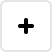
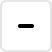
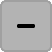
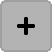
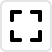
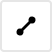
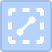
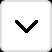
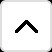
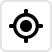
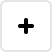
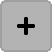
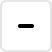
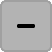
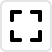
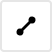
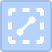
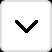
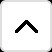
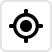

In [3]:
LetsPlot.setup_html()

In [4]:
def generate_month_colors(colormap):
    import numpy as np
    n = 12
    colors = [colormap[i] for i in np.linspace(0, len(colormap) - 1, n, dtype=int)]
    months = ['January', 'February', 'March', 'April', 'May', 'June', \
              'July', 'August', 'September', 'October', 'November', 'December']
    return {months[i]: colors[i] for i in range(n)}

top_size = 10
const_color = "black"
const_fill = "#3b528b"
month_color = generate_month_colors(cc.bmy)
religion_color = {
    "Orthodox": "#440154",
    "Christian": "#3b528b",
    "Hebrew": "#21918c",
    "Muslim": "#5ec962",
    "Hinduism": "#fde725",
}

<a id="data-preparation"></a>
### 2. Data preparation

In [5]:
def read_data():
    import os
    import pandas as pd
    data_dir = "data/countries"
    paths = (os.path.join(data_dir, f) for f in os.listdir(data_dir))
    dfs = []
    for file_path in filter(os.path.isfile, paths):
        dfs.append(pd.read_csv(file_path))
    return pd.concat(dfs, ignore_index=True)

def get_data():
    import pandas as pd
    name_replace = {
        "New Year": "New Year's Day",
    }
    type_replace = {
        "['Season']": "Season",
        "['Clock change/Daylight Saving Time']": "DST",
        "['Sporting event']": "Sport",
    }
    df = pd.read_csv("data/holidays.csv")
    df.columns = ["date", "holiday_name" ,"type", "country_name", "country_code"]
    df["date"] = pd.to_datetime(df["date"], format='mixed', utc=True)
    df["month"] = df["date"].dt.month
    df["month_name"] = pd.Categorical(
        df["date"].dt.month_name(), 
        categories=list(month_color.keys()), 
        ordered=True
    )
    df["week"] = df["date"].dt.isocalendar().week
    df["day_of_year"] = df["date"].dt.dayofyear
    df["day_of_month"] = df["date"].dt.day
    df["day_of_week"] = df["date"].dt.dayofweek
    df["day_of_week_name"] = df["date"].dt.day_name()
    df["date_name"] = df["month_name"].str.cat(df["day_of_month"].astype(str), sep=", ")
    df["holiday_name"] = df["holiday_name"].replace(name_replace)
    df["is_national"] = df["type"].str.contains("'National holiday'").map({True: "yes", False: "no"})
    df["religion"] = df["type"].str.extract(r"(Orthodox|Christian|Hebrew|Muslim|Hinduism)")
    df["is_religious"] = (~df["religion"].isna()).map({True: "yes", False: "no"})
    df["holiday_type"] = df["type"].map(type_replace).fillna("Holiday").astype(str)
    df.drop(columns=["type", "country_code"], inplace=True)
    df.drop_duplicates(subset=["country_name", "holiday_name", "day_of_year"], inplace=True)
    return df

def filter_df(df, col, value):
    result = df[df[col] == value].reset_index(drop=True)
    result.drop(columns=[col], inplace=True)
    return result

def get_distinct_holidays_df(df):
    return df.drop_duplicates(subset=["holiday_name", "day_of_year"]).reset_index(drop=True)

def get_countries_gdf(df, country_col):
    return geocode_countries(df[country_col].unique()).ignore_not_found().inc_res().get_boundaries()

def get_top_df(df, col):
    return df[col].value_counts().to_frame().reset_index().iloc[:top_size]

In [6]:
full_df = get_data()
print(full_df.shape)
full_df.head()

(7098, 15)


date          holiday_name country_name  month  \
0 2023-02-15 00:00:00+00:00        Liberation Day  Afghanistan      2   
1 2023-03-20 21:24:20+00:00         March Equinox  Afghanistan      3   
2 2023-03-21 00:00:00+00:00                Nauruz  Afghanistan      3   
3 2023-03-23 00:00:00+00:00  First Day of Ramadan  Afghanistan      3   
4 2023-04-22 00:00:00+00:00           Eid al-Fitr  Afghanistan      4   

  month_name  week  day_of_year  day_of_month  day_of_week day_of_week_name  \
0   February     7           46            15            2        Wednesday   
1      March    12           79            20            0           Monday   
2      March    12           80            21            1          Tuesday   
3      March    12           82            23            3         Thursday   
4      April    16          112            22            5         Saturday   

      date_name is_national religion is_religious holiday_type  
0  February, 15         yes      NaN           no      Holiday  
1     March, 20          no      NaN           no       Season  
2     March, 21          no      NaN           no      Holiday  
3     March, 23          no      NaN           no      Holiday  
4     April, 22         yes      NaN           no      Holiday

In [7]:
countries_gdf = get_countries_gdf(full_df, "country_name")
print(countries_gdf.shape)
countries_gdf.head()

(207, 3)


country   found name                                           geometry
0  Afghanistan  Afghanistan  MULTIPOLYGON (((60.87286 29.85855, 61.80162 30...
1      Albania      Albania  MULTIPOLYGON (((19.37279 41.85000, 19.40242 42...
2      Algeria      Algeria  MULTIPOLYGON (((-4.83333 25.00000, -8.66812 27...
3      Andorra      Andorra  MULTIPOLYGON (((1.72589 42.50270, 1.51284 42.4...
4       Angola       Angola  MULTIPOLYGON (((11.99615 -15.63033, 12.15321 -...

In [8]:
holidays_df = filter_df(full_df, "holiday_type", "Holiday")
print(holidays_df.shape)
holidays_df.head()

(6089, 14)


date          holiday_name country_name  month  \
0 2023-02-15 00:00:00+00:00        Liberation Day  Afghanistan      2   
1 2023-03-21 00:00:00+00:00                Nauruz  Afghanistan      3   
2 2023-03-23 00:00:00+00:00  First Day of Ramadan  Afghanistan      3   
3 2023-04-22 00:00:00+00:00           Eid al-Fitr  Afghanistan      4   
4 2023-04-23 00:00:00+00:00   Eid al-Fitr Holiday  Afghanistan      4   

  month_name  week  day_of_year  day_of_month  day_of_week day_of_week_name  \
0   February     7           46            15            2        Wednesday   
1      March    12           80            21            1          Tuesday   
2      March    12           82            23            3         Thursday   
3      April    16          112            22            5         Saturday   
4      April    16          113            23            6           Sunday   

      date_name is_national religion is_religious  
0  February, 15         yes      NaN           no  
1     March, 21          no      NaN           no  
2     March, 23          no      NaN           no  
3     April, 22         yes      NaN           no  
4     April, 23         yes      NaN           no

In [9]:
distinct_holidays_df = get_distinct_holidays_df(holidays_df)
print(distinct_holidays_df.shape)
distinct_holidays_df.head()

(3177, 14)


date          holiday_name country_name  month  \
0 2023-02-15 00:00:00+00:00        Liberation Day  Afghanistan      2   
1 2023-03-21 00:00:00+00:00                Nauruz  Afghanistan      3   
2 2023-03-23 00:00:00+00:00  First Day of Ramadan  Afghanistan      3   
3 2023-04-22 00:00:00+00:00           Eid al-Fitr  Afghanistan      4   
4 2023-04-23 00:00:00+00:00   Eid al-Fitr Holiday  Afghanistan      4   

  month_name  week  day_of_year  day_of_month  day_of_week day_of_week_name  \
0   February     7           46            15            2        Wednesday   
1      March    12           80            21            1          Tuesday   
2      March    12           82            23            3         Thursday   
3      April    16          112            22            5         Saturday   
4      April    16          113            23            6           Sunday   

      date_name is_national religion is_religious  
0  February, 15         yes      NaN           no  
1     March, 21          no      NaN           no  
2     March, 23          no      NaN           no  
3     April, 22         yes      NaN           no  
4     April, 23         yes      NaN           no

In [10]:
national_holidays_df = filter_df(full_df, "is_national", 'yes')
print(national_holidays_df.shape)
national_holidays_df.head()

(3365, 14)


date         holiday_name country_name  month  \
0 2023-02-15 00:00:00+00:00       Liberation Day  Afghanistan      2   
1 2023-04-22 00:00:00+00:00          Eid al-Fitr  Afghanistan      4   
2 2023-04-23 00:00:00+00:00  Eid al-Fitr Holiday  Afghanistan      4   
3 2023-04-24 00:00:00+00:00  Eid al-Fitr Holiday  Afghanistan      4   
4 2023-04-28 00:00:00+00:00   Afghan Victory Day  Afghanistan      4   

  month_name  week  day_of_year  day_of_month  day_of_week day_of_week_name  \
0   February     7           46            15            2        Wednesday   
1      April    16          112            22            5         Saturday   
2      April    16          113            23            6           Sunday   
3      April    17          114            24            0           Monday   
4      April    17          118            28            4           Friday   

      date_name religion is_religious holiday_type  
0  February, 15      NaN           no      Holiday  
1     April, 22      NaN           no      Holiday  
2     April, 23      NaN           no      Holiday  
3     April, 24      NaN           no      Holiday  
4     April, 28      NaN           no      Holiday

In [11]:
distinct_national_holidays_df = get_distinct_holidays_df(national_holidays_df)
print(distinct_national_holidays_df.shape)
distinct_national_holidays_df.head()

(1670, 14)


date         holiday_name country_name  month  \
0 2023-02-15 00:00:00+00:00       Liberation Day  Afghanistan      2   
1 2023-04-22 00:00:00+00:00          Eid al-Fitr  Afghanistan      4   
2 2023-04-23 00:00:00+00:00  Eid al-Fitr Holiday  Afghanistan      4   
3 2023-04-24 00:00:00+00:00  Eid al-Fitr Holiday  Afghanistan      4   
4 2023-04-28 00:00:00+00:00   Afghan Victory Day  Afghanistan      4   

  month_name  week  day_of_year  day_of_month  day_of_week day_of_week_name  \
0   February     7           46            15            2        Wednesday   
1      April    16          112            22            5         Saturday   
2      April    16          113            23            6           Sunday   
3      April    17          114            24            0           Monday   
4      April    17          118            28            4           Friday   

      date_name religion is_religious holiday_type  
0  February, 15      NaN           no      Holiday  
1     April, 22      NaN           no      Holiday  
2     April, 23      NaN           no      Holiday  
3     April, 24      NaN           no      Holiday  
4     April, 28      NaN           no      Holiday

<a id="visualizations"></a>
### 3. Visualizations

In [12]:
def get_map_plot(data, title, trans=None):
    return ggplot() + \
        geom_map(aes(fill="count"), data=data, show_legend=False, \
                 map=countries_gdf, map_join=["country_name", "country"],
                 color='white', size=.5,
                 tooltips=layer_tooltips().title("@country_name")\
                          .format("@count", 'd').line("holidays count|@count")) + \
        scale_fill_viridis(begin=.5, trans=trans) + \
        ggtitle(title) + \
        theme_void() + theme(plot_background=geom_rect(fill="#deebf7"))

gggrid([
    get_map_plot(holidays_df["country_name"].value_counts().to_frame().reset_index(), title="All holidays", trans='sqrt'),
    get_map_plot(national_holidays_df["country_name"].value_counts().to_frame().reset_index(), title="Only national holidays"),
    get_map_plot(holidays_df[
                     holidays_df["holiday_name"].str.contains("New Year", case=False)
                 ]["country_name"].value_counts().to_frame().reset_index(), title="New Year holidays"),
], ncol=2) + ggsize(1000, 800)

The first plot tells us that if you count all holidays (not just weekends), the US has a suspiciously high number of holidays (more than the number of days in a year).

The second plot shows how many national holidays (usually it is a weekends) there are.

The third plot shows who has how many New Year's holidays (not necessarily weekends).

In [13]:
us_holidays = holidays_df[holidays_df["country_name"] == "United States"].reset_index(drop=True)

ggplot(us_holidays) + \
    geom_dotplot(aes("week", fill="month_name"), method='histodot', binwidth=1, boundary=1e-3, \
                 color=const_color, stroke=.5, show_legend=False, \
                 tooltips=layer_tooltips().title("@month_name")\
                          .format("@week", 'd').line("week number|@week")\
                          .format("@..count..", 'd').line("week holidays count|@..count..")) + \
    scale_fill_manual(values=month_color) + \
    xlab("week number") + ylab("count") + \
    ggtitle("US holidays")

Let's look closer to the US. Here are all the holidays that there are (by week).

In [14]:
ggplot(distinct_national_holidays_df) + \
    geom_pie(aes(fill=as_discrete("month_name", order_by="month")), \
             hole=.65, size=35, color=const_color, spacer_color=const_color, \
             stroke=2, show_legend=False, \
             tooltips=layer_tooltips().line("count|@..count..").line("proportion|@..proppct.."), \
             labels=layer_labels().line("@month_name").size(10)) + \
    scale_fill_manual(values=month_color) + \
    ggtitle("Proportion of distinct holidays count per month") + \
    theme_void() + ggsize(600, 400)

The least festive month is December and the most festive month is April, if we take into account number of distinct holidays.

In [15]:
top_of_days_with_holiday_df = get_top_df(national_holidays_df, "day_of_year").sort_values(by="day_of_year").merge(
    national_holidays_df[["day_of_year", "date_name"]].drop_duplicates(), on="day_of_year"
)

ggplot(top_of_days_with_holiday_df) + \
    geom_bar(aes("count", as_discrete("day_of_year")), \
             stat='identity', orientation='y', \
             color=const_color, fill=const_fill, \
             labels=layer_labels().line("@date_name")) + \
    scale_fill_viridis(option='inferno') + \
    ggtitle("Number of all holidays in this day") + \
    theme(axis_title_y='blank', axis_text_y='blank')

If we look at which days of the year have the most national holidays (from all countries), the 1st of January is the most festive. 25 December and 1 May are not far behind.

In [16]:
ggplot(distinct_national_holidays_df.sort_values(by="day_of_week")) + \
    geom_bar(aes("day_of_week_name"), \
             color=const_color, fill=const_fill, \
             labels=layer_labels().line("@..sumpct..")) + \
    scale_fill_viridis() + \
    ggtitle("Proportion of distinct holidays count per week")

Looking at the distribution of national holidays by day of the week (relevant only for the year 2023), the most holidays fall on Monday and the least on Saturday.

In [17]:
top_of_holidays_df = national_holidays_df[national_holidays_df["holiday_name"].isin(
    get_top_df(national_holidays_df, "holiday_name")["holiday_name"].to_list()
)].sort_values(by="day_of_year").reset_index(drop=True)

ggplot(top_of_holidays_df) + \
    geom_count(aes("day_of_year", "holiday_name", group="date_name"), \
               alpha=.5, shape=21, color=const_color, fill=const_fill, show_legend=False, \
               tooltips=layer_tooltips().title("@holiday_name")\
                        .line("date|@date_name")\
                        .line("number of countries|@..n..")) + \
    ggmarginal('r', size=.2, layer=geom_bar(aes(y="holiday_name"), \
                                            orientation='y', width=.4, \
                                            color=const_color, fill=const_fill, \
                                            labels=layer_labels().line("@..count.."))) + \
    scale_size(range=[2, 20]) + \
    xlab("day of year") + ylab("holiday name") + \
    ggtitle("Top {0} of common national holidays".format(top_size), \
            "How many holidays with the same name exists in the different countries?") + \
    ggsize(1000, 400)

The most common is New Year's Day. For some holidays, the date can float - depending on the country. The most dispersed holiday is Independence Day - of course it is different for every country.

This plot should be taken with caution - I can only distinguish holidays by name, but it happens in the raw data that essentially the same holiday is named slightly differently in different countries.

In [18]:
def get_religious_comparison_plot(df, title):
    return ggplot(df) + \
        geom_bar(aes("is_religious"), color=const_color, fill=const_fill, \
                 tooltips='none', labels=layer_labels().line("@..sumpct..")) + \
        xlab("is religious") + \
        ggtitle(title)

gggrid([
    get_religious_comparison_plot(distinct_holidays_df, "Overall distinct holidays"),
    get_religious_comparison_plot(distinct_national_holidays_df, "Distinct national holidays"),
])

Most holidays are secular. Especially if we consider only national holidays.

In [19]:
def get_religions_df():
    import pandas as pd
    def get_df(df, national):
        return df[df["is_religious"] == "yes"]["religion"].value_counts()\
            .to_frame().reset_index().assign(subset=lambda _: national)
    return pd.concat([
        get_df(distinct_holidays_df, "overall"),
        get_df(distinct_national_holidays_df, "national only"),
    ]).reset_index(drop=True)

ggplot(get_religions_df()) + \
    geom_bar(aes("subset", weight="count", fill="religion"), \
             tooltips=layer_tooltips().title("@religion")\
                                      .line("count|@..count..")\
                                      .line("proportion|@..proppct..")) + \
    ggtitle("Number of distinct religious holidays") + \
    scale_fill_viridis() + \
    theme(axis_title_x='blank')

If we consider only religious holidays, then Hebrew has the most of them. However, if we look only at national holidays, then the greatest diversity is among the Orthodox.

In [20]:
def get_lollipop_data():
    import numpy as np
    n = 10
    x = np.linspace(-1, 1, 4 * n)
    y = [.65, .75] * 2 * n
    c = ["#f03b20", "#31a354", "#3182bd", "#ffeda0"] * n
    return dict(x=x, y=y, c=c)

text = """
2024 is coming and Lets-Plot team wishes you
all the best,
especially more time for yourself
while the AI does all the boring
and routine part of the work for you!
"""

ggplot() + \
    geom_rect(xmin=-1.05, xmax=1.05, ymin=-.6, ymax=1, fill='white', color=const_fill, linetype=4) + \
    geom_text(x=0, y=0, label=text, size=16, color=const_fill, \
              family="Times", fontface='bold') + \
    geom_lollipop(aes('x', 'y', fill='c'), data=get_lollipop_data(), \
                  intercept=1, size=3, shape=21, color=const_fill, \
                  show_legend=False) + \
    scale_fill_identity() + \
    ggsize(900, 300) + \
    theme_void()